<a href="https://colab.research.google.com/github/snmardi/Stonks_Project/blob/main/EDA_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import zipfile
import os
import shutil
import pandas as pd
import numpy as np

from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV, train_test_split

In [ ]:
DIRECTORY = ''

In [ ]:
#Для Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Разархивирование, не запускать если папка data уже существует
with zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/Data/data.zip', 'r') as zipFile:
    zipFile.extractall(DIRECTORY)
shutil.rmtree('__MACOSX')
for mode in ['train', 'test']:
    dealsList = os.listdir(f'{DIRECTORY}data/{mode}/{mode}_deals')
    for deals in dealsList:
        with zipfile.ZipFile(f'{DIRECTORY}data/{mode}/{mode}_deals/{deals}', 'r') as zipFile:
            zipFile.extractall(f'{DIRECTORY}data/{mode}/{mode}_deals')
        os.remove(f'{DIRECTORY}data/{mode}/{mode}_deals/{deals}')

In [ ]:
for mode in ['train', 'test']:
    main = pd.read_csv(f'{DIRECTORY}data/{mode}/{mode}.csv', sep = ',')
    for clmn in ['start_sum', 'income_rub', 'income_percent']:
        main[clmn] = main[clmn].str.replace(',', '.')
        main[clmn] = main[clmn].str.replace(' ', '')
    main['income_percent'].loc[main['income_percent'] == '-'] = np.nan
    main = main.astype({'start_sum': 'float', 'income_rub': 'float', 'income_percent': 'float'})
    os.remove(f'{DIRECTORY}data/{mode}/{mode}.csv')
    main.to_csv(f'{DIRECTORY}data/{mode}/{mode}.csv', index = False)

In [ ]:
def formatAccountCondition (id: int, mode: str):
  try:
    account_condition = pd.read_csv(f'{DIRECTORY}data/{mode}/{mode}_additional_info/id_{id}/account_condition_{id}.csv', sep = ';', index_col = 0)
  except FileNotFoundError:
    print('No such file for id', id)
    return None
  account_condition['date'] = pd.to_datetime(account_condition['date'], format='%Y-%m-%d')
  for clmn in ['start_sum', 'warranty_provision', 'free_funds']:
    account_condition[clmn].loc[account_condition[clmn] == '-'] = np.nan
    if account_condition[clmn].isna().sum() != account_condition.shape[0]:
      account_condition[[clmn, f'{clmn}_delt']] = account_condition[clmn].str.split('(', expand = True)
      account_condition[f'{clmn}_delt'] = account_condition[f'{clmn}_delt'].str.replace(')', '')
      account_condition[f'{clmn}_delt'] = account_condition[f'{clmn}_delt'].str.replace('+', '')
      account_condition[f'{clmn}_delt'].loc[account_condition[f'{clmn}_delt'] == '-'] = np.nan
    else:
      account_condition[f'{clmn}_delt'] = np.nan
  account_condition = account_condition.astype({'start_sum': 'float', 'warranty_provision': 'float', 'free_funds': 'float', 'start_sum_delt': 'float', 'warranty_provision_delt': 'float', 'free_funds_delt': 'float'})
  os.remove(f'{DIRECTORY}data/{mode}/{mode}_additional_info/id_{id}/account_condition_{id}.csv')
  account_condition.to_csv(f'{DIRECTORY}data/{mode}/{mode}_additional_info/id_{id}/account_condition_{id}.csv')
  return account_condition


In [ ]:
def formatReferencePoint (id: int, mode: str):
  try:
    reference_point = pd.read_csv(f'{DIRECTORY}data/{mode}/{mode}_additional_info/id_{id}/reference_point_{id}.csv', sep = ';', index_col = 0)
  except FileNotFoundError:
    print('No such file for id', id)
    return None
  for clmn in ['market', 'ticker', 'open_positions', 'price', 'end_day_balance', 'estimated_cost']:
    reference_point[clmn].loc[reference_point[clmn] == '-'] = np.nan
  if reference_point['open_positions'].isna().sum() != reference_point.shape[0]:
    reference_point[['open_positions', 'open_positions_delt']] = reference_point['open_positions'].str.split('(', expand = True)
    reference_point['open_positions_delt'] = reference_point['open_positions_delt'].str.replace(')', '')
    reference_point['open_positions_delt'] = reference_point['open_positions_delt'].str.replace('+', '')
    reference_point['open_positions_delt'].loc[reference_point['open_positions_delt'] == '-'] = np.nan
  else:
    reference_point['open_positions_delt'] = np.nan
  reference_point = reference_point.astype({'open_positions': 'float', 'price': 'float', 'end_day_balance': 'float', 'estimated_cost': 'float'})
  os.remove(f'{DIRECTORY}data/{mode}/{mode}_additional_info/id_{id}/reference_point_{id}.csv')
  reference_point.to_csv(f'{DIRECTORY}data/{mode}/{mode}_additional_info/id_{id}/reference_point_{id}.csv')
  return reference_point

In [ ]:
def addNamesToDeals (id: int, market: int, mode: str):
    try:
        deals = pd.read_csv(f'{DIRECTORY}data/{mode}/{mode}_deals/{market}_{id}.csv', names = ["datetime", "ticker", "quantity", "summ"], sep = ';')
    except FileNotFoundError:
        print('No such file for id', id)
        return None
    os.remove(f'{DIRECTORY}data/{mode}/{mode}_deals/{market}_{id}.csv')
    deals.to_csv(f'{DIRECTORY}data/{mode}/{mode}_deals/{market}_{id}.csv')
    return None

In [ ]:
for mode in ['train', 'test']:
    main = pd.read_csv(f'{DIRECTORY}data/{mode}/{mode}.csv', sep = ';')
    ids = main['id']
    for id in ids:
        formatAccountCondition(id, mode)
        formatReferencePoint(id, mode)
        for i in range(1, 4):
            addNamesToDeals(id, i, mode)

In [ ]:
# reading data
train = pd.read_csv('/content/data/train/train.csv')
final_test = pd.read_csv('/content/data/test/test.csv')

### **EDA**

**Основная информация по Data сетам:**


In [ ]:
final_test.drop('Unnamed: 0', inplace=True, axis=1)
final_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636 entries, 0 to 635
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              636 non-null    int64  
 1   nickname        636 non-null    object 
 2   broker          636 non-null    object 
 3   start_sum       636 non-null    float64
 4   request         636 non-null    int64  
 5   deals           636 non-null    int64  
 6   income_rub      636 non-null    float64
 7   income_percent  634 non-null    float64
dtypes: float64(3), int64(3), object(2)
memory usage: 39.9+ KB


Есть пропуски в income_percent, которые можно легко заполнить, посчитав отношение start_sum и income_rub

Также можно дропнуть столбец Unnamed: 0, тк он повторяет столбец id

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1527 entries, 0 to 1526
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              1527 non-null   int64  
 1   nickname        1527 non-null   object 
 2   broker          1527 non-null   object 
 3   start_sum       1527 non-null   float64
 4   request         1527 non-null   int64  
 5   deals           1527 non-null   int64  
 6   income_rub      1527 non-null   float64
 7   income_percent  1522 non-null   float64
 8   class           1527 non-null   int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 107.5+ KB


Есть пропуски в income_percent, которые можно легко заполнить, посчитав
отношение start_sum и income_rub

In [ ]:
final_test.describe()

,id,start_sum,request,deals,income_rub,income_percent
count,636.000000,6.360000e+02,636.000000,636.000000,6.360000e+02,634.000000
mean,312081.787736,4.655552e+05,648.072327,877.556604,-1.106748e+04,-2.069700
std,1240.865126,6.158335e+05,1859.593565,2720.140930,2.059010e+05,28.066482
min,309844.000000,1.000000e+05,1.000000,0.000000,-1.374407e+06,-95.940000
25%,310957.750000,1.000000e+05,17.000000,20.000000,-3.245275e+04,-11.472500
50%,312081.000000,1.824231e+05,88.500000,127.500000,-1.013665e+03,-0.735000
75%,313145.250000,5.098096e+05,457.750000,631.500000,9.094028e+03,5.215000
max,314280.000000,3.188704e+06,28191.000000,43240.000000,2.136743e+06,244.600000


start_sum, request, deals, income_rub, income_percent распредлены неравномерно тк std большое

In [ ]:
train.describe()

,id,start_sum,request,deals,income_rub,income_percent,class
count,1527.000000,1.527000e+03,1527.000000,1527.000000,1.527000e+03,1522.000000,1527.000000
mean,311944.578913,4.200718e+05,815.888671,833.396857,-1.513876e+04,-3.101222,2.992141
std,1243.150397,5.414697e+05,2867.258211,2575.873652,1.818546e+05,29.605822,1.410944
min,309828.000000,1.000000e+05,1.000000,0.000000,-1.872653e+06,-98.750000,1.000000
25%,310844.000000,1.000000e+05,20.000000,24.500000,-3.328679e+04,-12.855000,2.000000
50%,311894.000000,1.871230e+05,112.000000,145.000000,-1.101600e+03,-0.665000,3.000000
75%,313038.500000,4.798101e+05,556.000000,659.000000,8.264345e+03,3.835000,4.000000
max,314288.000000,4.103088e+06,56914.000000,56703.000000,2.122319e+06,398.800000,5.000000


start_sum, request, deals, income_rub, income_percent распредлены неравномерно тк std большое

**Восстановление пропущенных данных**

In [ ]:
final_test['income_percent'] = final_test['income_percent'].fillna((final_test['income_rub'] / final_test['start_sum'] * 100).round(2))
train['income_percent'] = train['income_percent'].fillna((train['income_rub'] / train['start_sum'] * 100).round(2))

In [ ]:
print('count of duplicates in final_test: ', final_test.duplicated().sum())
print('count of duplicates in train: ', train.duplicated().sum())

count of duplicates in final_test:  0
count of duplicates in train:  0


Дубликатов в дата-сетах не обнаружено

**Посмотрим количество пользователей у каждого брокера**

In [ ]:
grouped_final_test = final_test.groupby("broker", as_index=False).agg(
    count = ("broker", "count"))

print(grouped_final_test.sort_values(by='count'))

                    broker  count
1          АО «АЛЬФА-БАНК»      1
5           АО Риком-Траст      1
0              ITI Capital      3
2          АО «Банк ФИНАМ»      3
7          КИТ Финанс (АО)      3
10  ООО ИК "Фридом Финанс"      6
8             ООО «АЛОР +»      9
11            ПАО Сбербанк     15
6   ВТБ Капитал Инвестиции     78
4               АО «ФИНАМ»    127
3     АО «Открытие Брокер»    137
9       ООО «Компания БКС»    253


In [ ]:
grouped_train = train.groupby("broker", as_index=False).agg(
    count = ("broker", "count"))

print(grouped_train.sort_values(by='count'))

                    broker  count
1          АО «АЛЬФА-БАНК»      1
6   АО АКБ «ЦентроКредит»»      1
3      АО «НФК-Сбережения»      2
10              ООО «АТОН»      3
13     ПАО «Промсвязьбанк»      3
2          АО «Банк ФИНАМ»      4
8          КИТ Финанс (АО)      4
12  ООО ИК "Фридом Финанс"      8
0              ITI Capital      9
14            ПАО Сбербанк     27
9             ООО «АЛОР +»     29
7   ВТБ Капитал Инвестиции    165
4     АО «Открытие Брокер»    333
5               АО «ФИНАМ»    350
11      ООО «Компания БКС»    588


**Посмотрим распределение класса рискованности:**

array([[<Axes: title={'center': 'class'}>]], dtype=object)

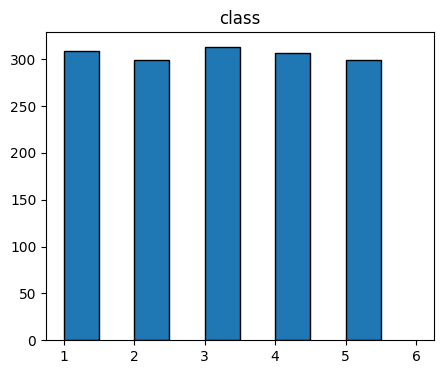

In [ ]:
train.hist(column= 'class',
           width=0.5,
           range= [1, 6],
           bins=5,
           figsize=(5, 4),
           ec='black',
           grid= False)

In [ ]:
grouped_train = train.groupby("class", as_index=False).agg(
     count = ("class", "count"))
print(grouped_train)

   class  count
0      1    309
1      2    299
2      3    313
3      4    307
4      5    299


Классы рискованности распределены равномерно

**Построим корреляционную матрицу**

<ipython-input-21-a3b8eacf772d>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrx = train.drop('id', axis=1).corr().round(3)


<Axes: >

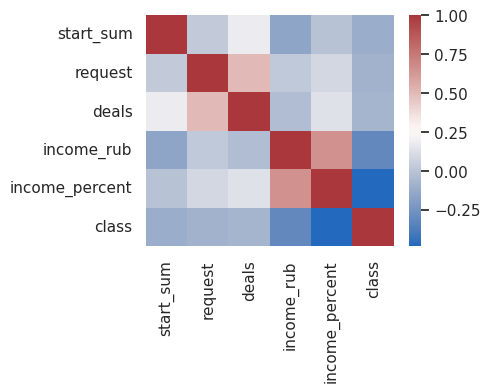

In [ ]:
import seaborn as sns

corr_matrx = train.drop('id', axis=1).corr().round(3)
sns.set(rc = {'figure.figsize':(4,3)})
sns.heatmap(corr_matrx, cmap="vlag", annot= False)

In [ ]:
print(corr_matrx)

                start_sum  request  deals  income_rub  income_percent  class
start_sum           1.000    0.030  0.178      -0.156          -0.013 -0.119
request             0.030    1.000  0.501       0.022           0.088 -0.085
deals               0.178    0.501  1.000      -0.036           0.134 -0.078
income_rub         -0.156    0.022 -0.036       1.000           0.654 -0.316
income_percent     -0.013    0.088  0.134       0.654           1.000 -0.483
class              -0.119   -0.085 -0.078      -0.316          -0.483  1.000


Есть очевидная корреляция между доходом в рублях и процентах и очевидная корреляция между количеством сделок и количеством заявок для сделок(deals, request). Остальные данные мало коррелируют друг с другом.

**Посмотрим на распределение классов в зависимости от различных параметров в таблице  с помощью графиков**

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:2095: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


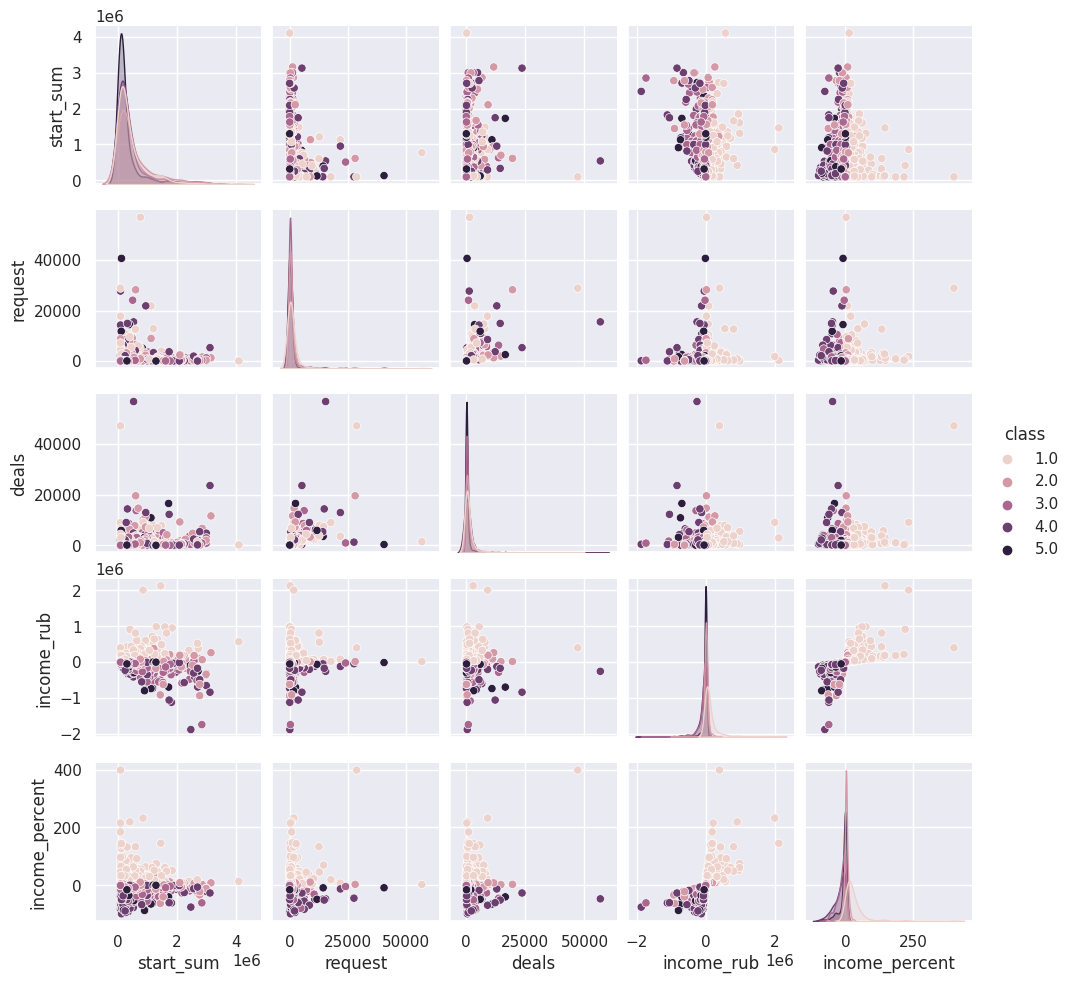

In [ ]:
import matplotlib.pyplot as plt

df_outer = pd.merge(train.drop('id', axis=1), final_test.drop(['id'], axis=1), how='outer')
sns.pairplot(df_outer, hue = 'class', size=2)
plt.show()

Исходя из графиков, доход получали самые не рискованные инвесторы, количество сделок и заявок для сделок у различных инвесторов +- одинаковое

**Создадим 3 новых датафрейма в соответствии с дополнительными таблица, при этом сконкатим таблицы с айди в 3 соотвествующих таблицы**

In [ ]:
train_additional_info_id_account_condition_list = []
train_additional_info_id_reference_point_list = []
train_additional_info_id_stats_table_list = []

account_condition_list = []
reference_point_list = []
stats_table_list = []
cnt_tables_list = []

main = pd.read_csv(f'/content/data/train/train.csv', sep = ',')
ids = main['id']

cnt_tables = 0
for id in ids:
  try:
    if not (pd.read_csv(f'/content/data/train/train_additional_info/id_{id}/account_condition_{id}.csv').empty):
      train_additional_info_id_account_condition_list.append(pd.read_csv(f'/content/data/train/train_additional_info/id_{id}/account_condition_{id}.csv'))
      account_condition_list.append(1)
      cnt_tables += 1
  except FileNotFoundError:
    #print('No such file for id', id)
    train_additional_info_id_account_condition_list.append(None)
  try:
      if not (pd.read_csv(f'/content/data/train/train_additional_info/id_{id}/reference_point_{id}.csv').empty):
        train_additional_info_id_reference_point_list.append(pd.read_csv(f'/content/data/train/train_additional_info/id_{id}/reference_point_{id}.csv'))
        reference_point_list.append(1)
        cnt_tables += 1
  except FileNotFoundError:
    #print('No such file for id', id)
    train_additional_info_id_reference_point_list.append(None)
  try:
    if not (pd.read_csv(f'/content/data/train/train_additional_info/id_{id}/stats_table_{id}.csv').empty):
      train_additional_info_id_stats_table_list.append(pd.read_csv(f'/content/data/train/train_additional_info/id_{id}/stats_table_{id}.csv', sep=';'))
      stats_table_list.append(1)
      cnt_tables += 1
  except FileNotFoundError:
    #print('No such file for id', id)
    train_additional_info_id_stats_table_list.append(None)
  cnt_tables_list.append(cnt_tables)
  cnt_tables = 0

train_additional_info_id_account_condition = pd.concat(train_additional_info_id_account_condition_list,
                                                       axis=0, join='outer', ignore_index=False, keys=ids)
train_additional_info_id_reference_point = pd.concat(train_additional_info_id_reference_point_list,
                                                     axis=0, join='outer', ignore_index=False, keys=ids)
train_additional_info_id_stats_table = pd.concat(train_additional_info_id_stats_table_list,
                                                 axis=0, join='outer', ignore_index=False, keys=ids)

distr_tables = pd.DataFrame({'id' : ids,
                             'count_tables' : cnt_tables_list})

print("инвесторы, неимеющие таблиц:")
print(distr_tables.loc[(distr_tables['count_tables']==0)])

**Посмотрим как таблицы распределены**

In [ ]:
distr_tables = pd.DataFrame({'name_table' : ['account_condition', 'reference_point', 'stats'],
                             'count_tables' : [sum(account_condition_list), sum(reference_point_list),
                                               sum(stats_table_list)]})

sns.set(rc = {'figure.figsize':(8,6)})
sns.barplot(x='name_table', y='count_tables', data=distr_tables)

Mного у кого отсутствует таблица reference_point, остальные почти одинаково присутствуют у пользователей

In [ ]:
train_additional_info_id_account_condition.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
train_additional_info_id_account_condition.reset_index(level = 'id').info()

In [ ]:
train_additional_info_id_account_condition.head()

date    market  start_sum  warranty_provision  free_funds  \
id                                                                          
311613 0  2022-09-20   Срочный  264530.00            32279.36   230995.99   
       1  2022-12-13   Срочный  264530.00            33360.77   286983.68   
311209 0  2022-09-19   Срочный  100000.00                0.00    95809.15   
       1  2022-12-13   Срочный  103693.18                0.00   115681.97   
313350 0  2022-10-12  Фондовый  576153.61                 NaN   576153.61   

          start_sum_delt  warranty_provision_delt  free_funds_delt  \
id                                                                   
311613 0             NaN                 32279.36        -33534.01   
       1             NaN                   138.44          -193.09   
311209 0             NaN                      NaN         -4190.85   
       1             NaN                      NaN            -1.26   
313350 0       276153.61                      NaN        276153.61   

         ;date;market;start_sum;warranty_provision;free_funds  
id                                                             
311613 0                                                NaN    
       1                                                NaN    
311209 0                                                NaN    
       1                                                NaN    
313350 0                                                NaN

In [ ]:
corr_matrx = train_additional_info_id_account_condition.corr().round(3)
sns.set(rc = {'figure.figsize':(4,3)})
sns.heatmap(corr_matrx, cmap="vlag", annot= False)

In [ ]:
train_additional_info_id_reference_point.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
train_additional_info_id_reference_point.reset_index(level = 'id').info()

In [ ]:
train_additional_info_id_reference_point.head(5)

market      ticker  open_positions  price  end_day_balance  \
id                                                                      
311613 0  Срочный    Si-12.22             1.0    NaN           1323.0   
       1  Срочный     Si-9.23             1.0    NaN           1125.0   
       2  Срочный  SBRF-12.22             1.0    NaN          -1234.0   
       3  Срочный    Si-12.23            -1.0    NaN           -814.0   
       4  Срочный  AFLT-12.22             1.0    NaN           -216.0   

          estimated_cost  open_positions_delt  \
id                                              
311613 0             NaN                  1.0   
       1             NaN                  1.0   
       2             NaN                  1.0   
       3             NaN                 -1.0   
       4             NaN                  1.0   

         ;market;ticker;open_positions;price;end_day_balance;estimated_cost  
id                                                                           
311613 0                                                NaN                  
       1                                                NaN                  
       2                                                NaN                  
       3                                                NaN                  
       4                                                NaN

In [ ]:
train_additional_info_id_reference_point['market'].value_counts()

инвесторы примерно одинаковое количество сделок совершали на срочном и фондовом рынках и чаще всего

In [ ]:
train_additional_info_id_stats_table.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
train_additional_info_id_stats_table.reset_index(level = 'id').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6104 entries, 0 to 3
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 6104 non-null   int64  
 1   Unnamed: 0         6104 non-null   object 
 2   start_amount       4819 non-null   float64
 3   purchase_requests  4819 non-null   float64
 4   deals              4819 non-null   float64
 5   money_turnover     4819 non-null   float64
 6   part_turnover      4819 non-null   object 
 7   income_percent     4819 non-null   float64
 8   income_rubles      4819 non-null   float64
 9   part_income        4819 non-null   object 
dtypes: float64(6), int64(1), object(3)
memory usage: 524.6+ KB


In [ ]:
train_additional_info_id_stats_table.head()

start_amount  purchase_requests  deals  money_turnover  \
id                                                                 
311613 0     264530.00             2081.0  913.0     53266448.62   
       1           NaN                NaN    NaN             NaN   
       2     264530.00             2081.0  913.0     53266448.62   
       3           NaN                NaN    NaN             NaN   
311209 0     103693.18              439.0  805.0     60822381.27   

         part_turnover  income_percent  income_rubles part_income  
id                                                                 
311613 0         100.0           21.37       56539.19       100.0  
       1           NaN             NaN            NaN         NaN  
       2         100.0           21.37       56539.19       100.0  
       3           NaN             NaN            NaN         NaN  
311209 0         100.0           10.95       11352.64       100.0

Отдельно обработаем train_deals тк сделки производились на разных рынках, поэтому создадим еще 3 датафрейма (train_deals_1...)

In [ ]:
train_deals_1_list = []
train_deals_2_list = []
train_deals_3_list = []

deals_1_list = []
deals_2_list = []
deals_3_list = []

cnt_tables_list = []
cnt_tables = 0
for id in ids:
  try:
    if not (pd.read_csv(f'/content/data/train/train_deals/1_{id}.csv').empty):
      train_deals_1_list.append(pd.read_csv(f'/content/data/train/train_deals/1_{id}.csv', sep=','))
      cnt_tables +=1
      deals_1_list.append(1)
  except FileNotFoundError:
    #print('No such file for id', id)
    train_deals_1_list.append(None)
  try:
    if not (pd.read_csv(f'/content/data/train/train_deals/2_{id}.csv').empty):
      train_deals_2_list.append(pd.read_csv(f'/content/data/train/train_deals/2_{id}.csv', sep=','))
      cnt_tables +=1
      deals_2_list.append(1)
  except FileNotFoundError:
    #print('No such file for id', id)
    train_deals_2_list.append(None)
  try:
     if not (pd.read_csv(f'/content/data/train/train_deals/3_{id}.csv').empty):
       train_deals_3_list.append(pd.read_csv(f'/content/data/train/train_deals/3_{id}.csv', sep=','))
       deals_3_list.append(1)
       cnt_tables +=1
  except FileNotFoundError:
     #print('No such file for id', id)
     train_deals_3_list.append(None)
  cnt_tables_list.append(cnt_tables)
  cnt_tables = 0

train_deals_1 = pd.concat(train_deals_1_list, axis=0, join='outer', ignore_index=False, keys=ids)
train_deals_2 = pd.concat(train_deals_2_list, axis=0, join='outer', ignore_index=False, keys=ids)
train_deals_3 = pd.concat(train_deals_3_list, axis=0, join='outer', ignore_index=False, keys=ids)

distr_tables = pd.DataFrame({'id' : ids,
                             'count_tables' : cnt_tables_list})

print("инвесторы, неимеющие таблиц:")
print(distr_tables.loc[(distr_tables['count_tables']==0)])

Посмотрим как распределены таблицы у пользователей

<Axes: xlabel='name_table', ylabel='count_tables'>

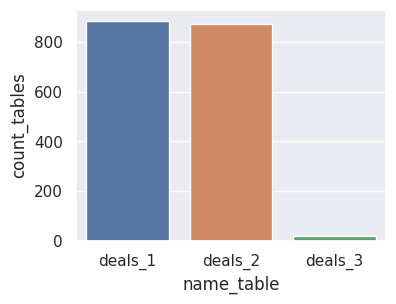

In [ ]:
distr_tables = pd.DataFrame({'name_table' : ['deals_1', 'deals_2', 'deals_3'],
                             'count_tables' : [sum(deals_1_list), sum(deals_2_list),
                                               sum(deals_3_list)]})

sns.barplot(x='name_table', y='count_tables', data=distr_tables)

На третьем рынке было произведено крайне мало сделок, на остальных +- одинаково

Посмотрим количество сделок, которые сделали инвесторы различных классов

In [ ]:
import matplotlib.pyplot as plt

for clas in range(1, 6):
    l=[]
    for id in train[train['class']==clas].id:
        if data[id]['deals'] is not None:
            l.append(len(data[id]['deals']))
    fig, ax = plt.subplots(figsize=(25, 3))

    ax.hist(l, bins = len(set(l)), range=(0, 40000))
    ax.set_xlabel('Number of deals')
    ax.set_ylabel('Frequency')
    ax.set_title(f"Class {clas} Histogram")

    plt.show()

Исходя из графиков, видно, что чаще всех сделки совершали инвесторы 5 класса, 1 класс совершал меньше всего сделок, 2-4 классы примерно одинаково

# Мусорка